Population predictor
=============

Using Deep Learning
------------

The following things are being done here.
1. Load dataset.npy file for the TPM count from quant.sf file. If not present:
    a. Read from the quant.sf files to a numpy array dataset.
    b. Save it using numpy.save file for faster access.
2. Perform Dimensionality reduction. Possible methods:
    a. PCA (Problems: Not for dataset with number of features larger than number of samples).
    b. TSNE (Slow)
    c. Encoder (Deep learning approach to encode into a lower dimensional form)
3. Apply the model to this reduced feature vector. Possible models:
    a. Fully connected neural network with softmax loss.
    b. Conv1D
    c. ...

In [5]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
import yadlt
from sklearn.model_selection import train_test_split
import pickle
from sklearn.metrics import f1_score

In [107]:
path = r'EquivalenceClasses' # equivalence class path
rows = os.listdir(path)
eq_class_set = set()
for dir in rows:        
    file_path = os.path.join(path, dir)            
    file_path = os.path.join(file_path, r'bias\aux_info\eq_classes.txt')        
    try:
        with open(file_path) as file:
            file_content = file.read().split('\n')
            offset = int(file_content[0]) + 2
            equivalence_classes = file_content[offset:]
            
            for eq in equivalence_classes: # TODO: remove slice
                    #print(eq)
                key = str(sorted(filter(None, eq[1:-1].split('\t'))))
                    #print(key)
                eq_class_set.add(key)
    except:
        pass

columns = list(eq_class_set)
columns_index = {columns[i]:i for i in range(len(columns))}
row_index = {rows[i]:i for i in range(len(rows))}
mat = np.zeros(shape=(len(rows), len(columns)), dtype=int)

for dir in rows:        
    file_path = os.path.join(path, dir)            
    file_path = os.path.join(file_path, r'bias\aux_info\eq_classes.txt')        
    try:
        with open(file_path) as file:
            file_content = file.read().split('\n')
            offset = int(file_content[0]) + 2
            equivalence_classes = file_content[offset:]    
            r = row_index[dir]            
            for eq in equivalence_classes: # TODO: remove slice                  
                val = int(eq[-1])
                key = str(sorted(filter(None, eq[1:-1].split('\t'))))
                c = columns_index[key]
                mat[r][c] = val
                eq_class_set.add(key)
    except:
        pass
mat

array([[0, 2, 1, ..., 1, 1, 6],
       [0, 5, 0, ..., 2, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [7, 0, 2, ..., 1, 0, 5]])

In [4]:
from xgboost import XGBClassifier

ModuleNotFoundError: No module named 'xgboost'

Read the input from the quant.sf file.

In [11]:
# Read the CSV file to map samples vs labels.
data_frame = pd.read_csv('p1_train.csv')
labels = sorted(list(set(data_frame['label'])))

num_of_transcripts = 199324
num_of_samples = data_frame.shape[0]
num_labels = len(labels)

dataset = np.empty((num_of_samples, num_of_transcripts), dtype=np.float32)
sample_vs_label = np.empty(num_of_samples, dtype='int')
samples = np.empty(num_of_samples, dtype='<U9')

for index, row in data_frame.iterrows():
    if(index >= num_of_samples): break
    sample_vs_label[index] = labels.index(row['label'])
    samples[index] = row['accession']
print(sample_vs_label)

[0 1 0 0 1 2 3 2 1 2 2 4 4 2 2 3 3 0 0 2 1 3 2 2 4 0 0 4 1 4 0 1 2 4 4 3 3
 2 0 2 2 1 1 1 3 4 1 3 4 3 4 0 2 4 0 4 4 2 3 2 2 1 4 3 2 1 4 0 3 3 4 0 0 4
 0 4 3 0 0 0 0 2 0 2 0 1 1 3 1 0 0 2 1 3 3 2 0 3 4 4 2 3 0 2 1 4 4 3 4 4 1
 0 3 3 1 1 2 1 1 1 4 3 3 1 0 0 3 0 1 3 3 0 3 2 0 0 1 3 1 2 4 3 4 1 3 4 3 1
 4 3 2 0 0 4 3 2 1 3 0 1 2 0 3 3 2 1 4 4 1 1 1 3 3 3 2 4 3 3 0 0 2 1 1 0 1
 1 4 0 0 2 0 3 4 3 1 2 3 0 2 2 2 0 3 4 3 3 4 3 0 4 4 2 3 1 1 3 1 3 0 4 0 1
 4 1 3 2 4 0 2 2 1 4 2 1 0 1 4 4 3 4 1 4 1 1 1 1 1 1 1 0 4 2 2 4 3 0 0 4 0
 3 2 4 2 2 4 3 3 3 1 0 2 0 1 0 0 4 2 2 3 4 0 2 4 0 0 0 1 2 3 4 2 4 4 2 1 2
 0 2 2 4 3 3 3 2 2 4 1 3 1 4 3 2 1 4 4 4 2 4 1 2 0 3 1 1 0 3 1 2 2 3 2 1 4
 0 1 4 2 4 0 1 4 0 3 2 2 2 1 1 0 1 0 1 2 0 2 1 4 3 2 1 2 2 2 1 2 4 3 0 0]


Try and read from any saved 'dataset.npy' file. If present then load it to numpy array dataset, else just read it from all possible folders.

In [12]:
%%time
if (os.path.isfile('dataset.npy')):
    dataset = np.load('dataset.npy')
else:
    TRAIN_PATH = './train/'
    # Read the 'quant.sf' value here for each sample.
    for i in range(num_of_samples):
        if i % 20 == 0: print(i)
        file_name = TRAIN_PATH + samples[i] + '/bias/quant.sf'
        quant_sf = np.genfromtxt(file_name, delimiter='\t', usecols=3, skip_header=True, dtype=np.float32)
        dataset[i] = quant_sf

    # Using https://i.stack.imgur.com/4d6yo.png to judge the best way to save the dataset as a npy file
    # for faster reloading of numpy array.
    np.save('dataset.npy', dataset)


CPU times: user 1.41 ms, sys: 216 ms, total: 218 ms
Wall time: 288 ms


*** 
***
## XGBOOST

Gotta try!

In [31]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

In [49]:
X = dataset
Y = sample_vs_label
# split data into train and test sets

label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(Y)
label_encoded_y = label_encoder.transform(Y)

seed = 7
test_size = 0.33

skf = StratifiedKFold(n_splits=3)

accuracy = []
f1_sc = []
i=0
for train_index, test_index in skf.split(X, label_encoded_y):
    print("Fold", i)
    i+=1
#     X_train, X_test = select_features(X[train_index], label_encoded_y[train_index], X[test_index])
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = label_encoded_y[train_index], label_encoded_y[test_index]
    # fit model no training data
    model = XGBClassifier()
    model.fit(X_train, y_train)
    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy.append(accuracy_score(y_test, predictions))
    f1_sc.append(f1_score(y_test, predictions, average=None))
    print("F1-Score: ", [ '%.2f' % elem for elem in f1_sc[-1] ])
    print("Accuracy: %.2f%%" % (accuracy[-1] * 100.0))

Fold 0
F1-Score:  ['0.94', '0.83', '0.81', '0.67', '0.94']
Accuracy: 83.87%
Fold 1
F1-Score:  ['0.98', '0.96', '0.89', '0.84', '1.00']
Accuracy: 93.55%
Fold 2
F1-Score:  ['0.92', '0.79', '0.86', '0.79', '0.98']
Accuracy: 86.78%


In [68]:
print("Mean F1-Score:\n\t", "\n\t".join(['%s: %.2f%%' % (labels[i], elem) for\
                                          (i, elem) in enumerate(np.mean(f1_sc, axis=0)*100)]))
print("Mean Accuracy: %.2f%%" % (np.mean(accuracy) * 100.0))

Mean F1-Score:
	 CEU: 94.61%
	FIN: 86.11%
	GBR: 85.12%
	TSI: 76.76%
	YRI: 97.25%
Mean Accuracy: 88.07%


***
***
## DEEP LEARNING



In [41]:
def select_features(train_data, train_data_label, test_data):
    scaler = StandardScaler(copy=True, with_mean=True, with_std=True).fit(train_data)
    train_sample = scaler.transform(train_data)
    test_sample = scaler.transform(test_data)
    
#     pca = PCA(n_components=100)
#     pca.fit(train_sample)
#     train_sample = pca.transform(train_sample)
#     test_sample = pca.transform(test_sample)
    
    clf = ExtraTreesClassifier()
    clf = clf.fit(train_sample, train_data_label)
    clf.feature_importances_  

    model = SelectFromModel(clf, prefit=True)
    train_sample = model.transform(train_sample)
    test_sample = model.transform(test_sample)
    with open('scaler1.pickle', 'wb') as handle:
        pickle.dump(scaler, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open('tree_based_model1.pickle', 'wb') as handle:
        pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return train_sample, test_sample

In [8]:
def reformat(labels):
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return labels
print(sample_vs_label[:5])
sample_vs_label = reformat(sample_vs_label)
print(sample_vs_label[:5])

[0 1 0 0 1]
[[ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]]


# Tree-based feature selection

Tree-based estimators (see the sklearn.tree module and forest of trees in the sklearn.ensemble module) can be used to compute feature importances, which in turn can be used to discard irrelevant features (when coupled with the sklearn.feature_selection.SelectFromModel meta-transformer):

In [6]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

# Neural Network
## FC Connected layer
HyperParameters

In [53]:
batch_size = 50
num_hidden_nodes = [800, 100, 20]
num_layers = len(num_hidden_nodes)
dropout_fraction = 0.5
beta_1_value = 1e-3
beta_2_value = 1e-3
learning_step = 1e-4
decay_steps = 1e6
decay_rate = 0.65
k_fold_splits = 5
num_steps = 2000

# Running the neural net
## Training for num_steps epochs

In [54]:
def run_nn(train_dataset, train_labels, test_data, test_labels, valid_dataset, valid_labels):
    num_of_transcripts = train_dataset.shape[1]
    input_size = [num_of_transcripts]+num_hidden_nodes
    graph = tf.Graph()
    with graph.as_default():
        # Input
        tf_train_dataset = tf.placeholder(tf.float32, shape=
                                         (batch_size, None))
        tf_train_labels = tf.placeholder(tf.float32, shape=
                                        (batch_size, num_labels))
        tf_test_data = tf.placeholder(tf.float32, shape=
                                        (None, None))
#         print(tf_test_data.shape)
        global_step = tf.Variable(0)

        # Weights
        weights1 = []
        biases1 = []
        beta1 = []

        for i in range(num_layers):
            weights1.append(tf.Variable(tf.truncated_normal([input_size[i], num_hidden_nodes[i]],\
                                                            stddev=np.sqrt(2.0 / (input_size[i])))))
            biases1.append(tf.Variable(tf.zeros([num_hidden_nodes[i]])))
            beta1.append(beta_1_value)
        biases2 = tf.Variable(tf.zeros([num_labels]))
        weights2 = tf.Variable(tf.truncated_normal([input_size[-1], num_labels],\
                                                   stddev=np.sqrt(2.0 / input_size[-1])))
        beta2 = beta_2_value


        # Training Computation
        lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset,weights1[0]) + biases1[0])
        drop1 = tf.nn.dropout(lay1_train, dropout_fraction)
        for i in range(1, num_layers):
#             print(lay1_train.shape)
#             lay1_train = tf.nn.relu(tf.matmul(drop1, weights1[i]) + biases1[i])
            batch_mean, batch_var = tf.nn.moments(drop1,[0])
            scale = tf.Variable(tf.ones(drop1.shape))
            beta = tf.Variable(tf.zeros(drop1.shape))
            lay1_train = tf.nn.relu(tf.matmul(tf.nn.batch_normalization(\
                                                                        drop1,batch_mean,batch_var,\
                                                                        beta,scale,1e-3), weights1[i])\
                                    + biases1[i])
            drop1 = tf.nn.dropout(lay1_train, dropout_fraction)
        logits = tf.matmul(drop1, weights2) + biases2
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))\
                               + beta2 * tf.nn.l2_loss(weights2)
        for i in range(num_layers):
            loss += beta1[i] * tf.nn.l2_loss(weights1[i]) 

        # Optimizer
        learning_rate = tf.train.exponential_decay(learning_step, global_step, decay_steps, decay_rate, staircase=True)
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)

        # Predictions
        train_prediction = tf.nn.softmax(logits)

        lay1_test = tf.nn.relu(tf.matmul(tf_test_data, weights1[0]) + biases1[0])
        for i in range(1, num_layers):
            lay1_test = tf.nn.relu(tf.matmul(lay1_test, weights1[i]) + biases1[i])
        logits_test = tf.matmul(lay1_test, weights2) + biases2
        test_prediction = tf.nn.softmax(logits_test)

    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        # Add ops to save and restore all the variables.
        saver = tf.train.Saver()
        print('Initialised')

        minibatch.append(list())
        validation.append(list())
        steps.append(list())
        #     train_dataset = train_sample
        #     train_labels = train_data_label
        for step in range(num_steps):
            offset = (step * batch_size) % \
                     (train_labels.shape[0] - batch_size)

            batch_data = train_dataset[offset:offset + batch_size, :]
            batch_labels = train_labels[offset:offset + batch_size, :]

            feed_dict = {tf_train_dataset: batch_data, \
                         tf_train_labels: batch_labels}
            _, l, predictions = session.run([optimizer, loss, \
                                             train_prediction], feed_dict=feed_dict)

                #                 print("Minibatch accuracy: %.1f%% " % accuracy(predictions, batch_labels))
            minibatch[-1].append(accuracy(predictions, batch_labels))
            #                 print("Validation accuracy %d: %.1f%% " % (step, accuracy(test_prediction.eval(feed_dict={tf_test_data : valid_dataset}), valid_labels)))
            validation[-1].append(
                accuracy(test_prediction.eval(feed_dict={tf_test_data: valid_dataset}), valid_labels))
            steps[-1].append(step)
            if step % int(num_steps / 4) == 0:
                print("Step: %d : Validation Accuracy: %.1f%%" % (step, validation[-1][-1]))
        predicted_labels = test_prediction.eval(feed_dict={tf_test_data : test_data})
        result = accuracy(predicted_labels, test_labels)
        f1_sc = f1_score(np.argmax(test_labels, 1), np.argmax(predicted_labels, 1), average=None)
        print("Test Accuracy: %.1f%%" % (result))
        print("F1-Score: ", [ '%.2f' % elem for elem in f1_sc ])
    
#     save_path = saver.save(session, "./model1.ckpt")
#     print("Model saved in file: %s" % save_path)

    return result



In [55]:
result = list()
i = 0
accuracy_val = []
minibatch = list()
validation = list()
steps = list()
skf = KFold(n_splits=k_fold_splits)
for train_index, test_index in skf.split(dataset, sample_vs_label):
    train_data, test_data = dataset[train_index], dataset[test_index]
    train_labels, test_labels = sample_vs_label[train_index], sample_vs_label[test_index]
    train_data, test_data = select_features(train_data, train_labels, test_data)    
    train_dataset, valid_dataset, train_labels, valid_labels = train_test_split(train_data,\
                                                                                train_labels, \
                                                                                test_size=0.2)
    result.append(run_nn(train_dataset, train_labels, test_data, test_labels, valid_dataset, valid_labels))

print("Mean result: %.1f%%" % np.mean(result))

Initialised
Step: 0 : Validation Accuracy: 18.6%
Step: 500 : Validation Accuracy: 54.2%
Step: 1000 : Validation Accuracy: 62.7%
Step: 1500 : Validation Accuracy: 64.4%
Test Accuracy: 67.6%
F1-Score:  ['0.83', '0.56', '0.69', '0.24', '0.87']
Initialised
Step: 0 : Validation Accuracy: 20.3%
Step: 500 : Validation Accuracy: 57.6%
Step: 1000 : Validation Accuracy: 66.1%
Step: 1500 : Validation Accuracy: 72.9%
Test Accuracy: 77.0%
F1-Score:  ['0.84', '0.79', '0.63', '0.65', '0.90']
Initialised
Step: 0 : Validation Accuracy: 11.9%
Step: 500 : Validation Accuracy: 64.4%
Step: 1000 : Validation Accuracy: 69.5%
Step: 1500 : Validation Accuracy: 74.6%
Test Accuracy: 74.3%
F1-Score:  ['0.93', '0.88', '0.69', '0.33', '0.77']
Initialised
Step: 0 : Validation Accuracy: 25.4%
Step: 500 : Validation Accuracy: 64.4%
Step: 1000 : Validation Accuracy: 72.9%
Step: 1500 : Validation Accuracy: 72.9%
Test Accuracy: 87.8%
F1-Score:  ['0.93', '0.82', '0.79', '0.84', '0.97']
Initialised
Step: 0 : Validation Acc

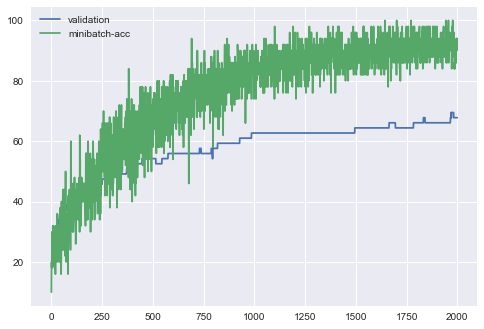

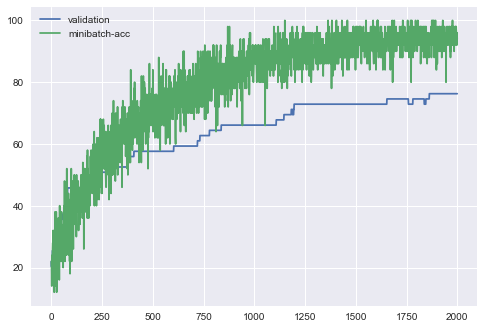

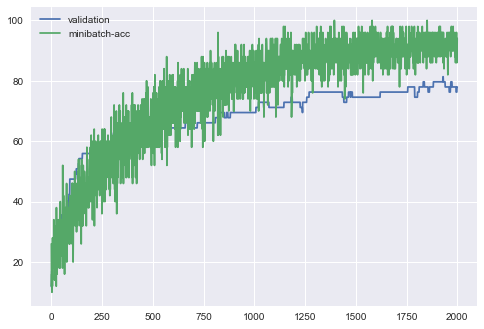

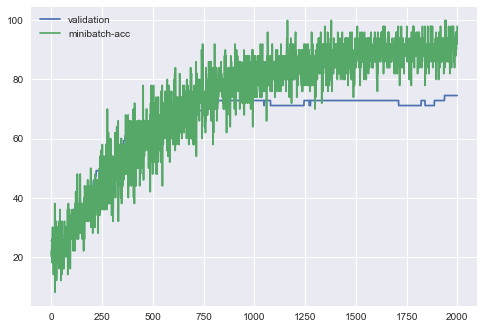

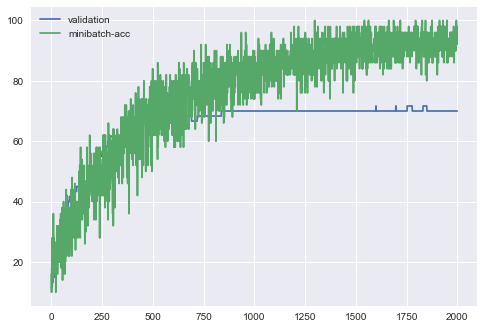

In [56]:
for idx in range(len(result)):
    p = plt.figure()
    plt.plot(steps[idx], validation[idx], label='validation')
    plt.plot(steps[idx], minibatch[idx], label='minibatch-acc')
    plt.legend()
    plt.show()

# Test Prediction

In [ ]:
with open('scaler1.pickle', 'rb') as handle:
    scaler = pickle.load(handle)
with open('tree_based_model1.pickle', 'rb') as handle:
    model = pickle.load(handle)

test_sample = scaler.transform(test_data)
test_sample = model.transform(test_sample)

In [ ]:
print(np.std(test_sample))
print(np.std(train_sample))

In [ ]:
with tf.Session(graph=graph) as session:
    # Restore variables from disk.
    saver.restore(session, "./model1.ckpt")
    print("Model restored.")
    print("Test accuracy: %.1f%%" % \
          accuracy(test_prediction.eval(feed_dict={tf_test_data : test_sample}), test_data_label))